In [ ]:
# !pip install torchvision==0.16.0
# !pip install seaborn
# # 安装后点击上方 Restart the kernal

In [2]:
# 步骤一：导入相关库
import os
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [4]:
# 步骤二：加载数据集
# 2.1 设置超参数
EPOCH = 10
BATCH_SIZE = 64
LR = 0.003
DOWNLOAD_CIFAR = False
DEVICE = 'cuda'

# 2.2 数据预处理
transform = transforms.Compose([
    transforms.ToTensor(), # 请在此处编写代码：ToTensor
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)) # 请在此处编写代码：Normalize（均值与方差）
])

# 2.3 检查是否需要下载数据集
if not(os.path.exists('./cifar/')) or not os.listdir('./cifar/'):
    DOWNLOAD_CIFAR = True

# 2.4 加载训练集和测试集
train_data = torchvision.datasets.CIFAR10(
    root='./cifar/',
    train=True,
    transform=transform,
    download=DOWNLOAD_CIFAR
)
test_data = torchvision.datasets.CIFAR10(
    root='./cifar/',
    train=False,
    transform=transform,
    download=DOWNLOAD_CIFAR
)


# 2.5 封装数据加载器
train_loader = Data.DataLoader( # 请在此处编写代码
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2 # Optional: depending on your system
)
test_loader = Data.DataLoader( # 请在此处编写代码
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2 # Optional: depending on your system
)

In [5]:
# 步骤三：CNN模型设计
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            # Block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1), # 请在此处编写代码：Conv2d
            nn.BatchNorm2d(32), # 请在此处编写代码：BatchNorm2d
            nn.ReLU(), # 请在此处编写代码：ReLU
            nn.MaxPool2d(kernel_size=2, stride=2), # 请在此处编写代码：MaxPool2d (Output: 32x16x16)

            # Block 2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # (Output: 64x8x8)
        )
        self.fc = nn.Sequential(
            nn.Flatten(), # 请在此处编写代码：Flatten
            nn.Linear(64 * 8 * 8, 512), # 请在此处编写代码：Linear (Input features: 64*8*8)
            nn.ReLU(), # 请在此处编写代码：ReLU
            nn.Dropout(0.5), # 请在此处编写代码：Dropout
            nn.Linear(512, 10) # 请在此处编写代码：Linear (Output classes: 10 for CIFAR-10)
        )

    def forward(self, x):
        x = self.conv(x) # 请在此处编写代码
        x = self.fc(x) # 请在此处编写代码
        return x

# 3.2 实例化模型并迁移到设备
cnn = CNN() # 请在此处编写代码
cnn = cnn.to(DEVICE)

print(cnn)

CNN(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [6]:
# 步骤四：设置损失函数与优化器
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR) # 请在此处编写代码：Adam优化器
criterion = nn.CrossEntropyLoss() # 请在此处编写代码：交叉熵损失

In [7]:
# 步骤五：训练模型
train_losses = []
test_accuracies = []

# 5.1 定义训练函数
def train(epoch):
    cnn.train() # 请在此处编写代码：切换到训练模式（model.train()）
    epoch_loss = 0.0
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}")):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE) # 请在此处编写代码：将 inputs 和 targets 迁移到设备（to(DEVICE)）

        optimizer.zero_grad() # 请在此处编写代码：清除梯度（optimizer.zero_grad）
        outputs = cnn(inputs) # 请在此处编写代码：前向传播（model(inputs)）
        loss = criterion(outputs, targets) # 请在此处编写代码：计算损失（criterion(outputs, targets)）
        loss.backward() # 请在此处编写代码：反向传播（loss.backward）
        optimizer.step() # 请在此处编写代码：参数更新（optimizer.step）

        epoch_loss += loss.item() # 请在此处编写代码：累计损失（epoch_loss += loss.item()）

        # 可选：每 N 批次打印中间 loss
        if batch_idx % 100 == 0:
            current_loss = loss.item() # 请在此处编写代码：打印当前 batch 的平均 loss (using loss.item() for current batch loss)
            print(f"Epoch [{epoch+1}/{EPOCH}], Batch [{batch_idx}/{len(train_loader)}], Loss: {current_loss:.4f}")

    avg_epoch_loss = epoch_loss / len(train_loader) # 请在此处编写代码：计算 epoch 平均 loss
    train_losses.append(avg_epoch_loss)
    print(f"Epoch [{epoch+1}] Average Train Loss: {avg_epoch_loss:.4f}")

# 5.2 定义测试函数（返回 acc，预测标签，真实标签）
def test():
    cnn.eval() # 请在此处编写代码：切换模型为评估模式
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad(): # 请在此处编写代码：关闭梯度计算（torch.no_grad）
        for inputs, targets in tqdm(test_loader, desc="Testing"):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE) # 请在此处编写代码：数据迁移到DEVICE
            outputs = cnn(inputs) # 请在此处编写代码：前向传播
            _, predicted = torch.max(outputs.data, 1) # 请在此处编写代码：获取预测标签（outputs.max(dim=1)）

            total += targets.size(0) # 请在此处编写代码：更新 total 和 correct 数量
            correct += (predicted == targets).sum().item() # 请在此处编写代码：更新 total 和 correct 数量

            all_preds.append(predicted.cpu()) # 请在此处编写代码：保存预测和真实标签到 all_preds 和 all_labels
            all_labels.append(targets.cpu()) # 请在此处编写代码：保存预测和真实标签到 all_preds 和 all_labels

    acc = 100. * correct / total # 请在此处编写代码：计算准确率（百分比形式）
    pred_y = torch.cat(all_preds)
    true_y = torch.cat(all_labels)
    return acc, pred_y, true_y

# 5.3 开始训练过程
os.makedirs('./output', exist_ok=True)

for epoch in range(EPOCH):
    train(epoch) # 请在此处编写代码：调用 train 函数
    acc, _, _ = test() # 请在此处编写代码：调用 test 函数
    test_accuracies.append(acc) # 请在此处编写代码：保存本轮测试准确率
    print(f"Test Accuracy after Epoch [{epoch+1}]: {acc:.2f}%") # Corrected to print with % and match final_acc print format

Training Epoch 1:   2%|▏         | 17/782 [00:00<00:27, 27.81it/s]

Epoch [1/10], Batch [0/782], Loss: 2.3867


Training Epoch 1:  17%|█▋        | 131/782 [00:01<00:03, 167.53it/s]

Epoch [1/10], Batch [100/782], Loss: 1.8186


Training Epoch 1:  31%|███       | 240/782 [00:01<00:02, 202.69it/s]

Epoch [1/10], Batch [200/782], Loss: 1.6039


Training Epoch 1:  42%|████▏     | 328/782 [00:02<00:02, 207.45it/s]

Epoch [1/10], Batch [300/782], Loss: 1.6676


Training Epoch 1:  56%|█████▌    | 438/782 [00:02<00:01, 209.83it/s]

Epoch [1/10], Batch [400/782], Loss: 1.6486


Training Epoch 1:  67%|██████▋   | 526/782 [00:03<00:01, 209.72it/s]

Epoch [1/10], Batch [500/782], Loss: 1.5256


Training Epoch 1:  81%|████████▏ | 636/782 [00:03<00:00, 211.31it/s]

Epoch [1/10], Batch [600/782], Loss: 1.4492


Training Epoch 1:  92%|█████████▏| 722/782 [00:04<00:00, 209.27it/s]

Epoch [1/10], Batch [700/782], Loss: 1.5363


Training Epoch 1: 100%|██████████| 782/782 [00:04<00:00, 168.23it/s]


Epoch [1] Average Train Loss: 1.7393


Testing: 100%|██████████| 157/157 [00:00<00:00, 167.47it/s]


Test Accuracy after Epoch [1]: 53.18%


Training Epoch 2:   0%|          | 1/782 [00:00<01:47,  7.26it/s]

Epoch [2/10], Batch [0/782], Loss: 1.6984


Training Epoch 2:  16%|█▌        | 126/782 [00:00<00:03, 194.85it/s]

Epoch [2/10], Batch [100/782], Loss: 1.2670


Training Epoch 2:  30%|██▉       | 233/782 [00:01<00:02, 202.27it/s]

Epoch [2/10], Batch [200/782], Loss: 1.4365


Training Epoch 2:  43%|████▎     | 338/782 [00:01<00:02, 203.69it/s]

Epoch [2/10], Batch [300/782], Loss: 1.4296


Training Epoch 2:  54%|█████▍    | 423/782 [00:02<00:01, 203.56it/s]

Epoch [2/10], Batch [400/782], Loss: 1.3813


Training Epoch 2:  67%|██████▋   | 527/782 [00:02<00:01, 183.96it/s]

Epoch [2/10], Batch [500/782], Loss: 1.4091


Training Epoch 2:  81%|████████  | 635/782 [00:03<00:00, 204.40it/s]

Epoch [2/10], Batch [600/782], Loss: 0.9681


Training Epoch 2:  95%|█████████▍| 742/782 [00:03<00:00, 205.44it/s]

Epoch [2/10], Batch [700/782], Loss: 1.3180


Training Epoch 2: 100%|██████████| 782/782 [00:04<00:00, 193.49it/s]


Epoch [2] Average Train Loss: 1.3676


Testing: 100%|██████████| 157/157 [00:00<00:00, 178.27it/s]


Test Accuracy after Epoch [2]: 62.42%


Training Epoch 3:   1%|          | 7/782 [00:00<00:11, 66.05it/s]

Epoch [3/10], Batch [0/782], Loss: 1.1951


Training Epoch 3:  18%|█▊        | 138/782 [00:00<00:03, 204.40it/s]

Epoch [3/10], Batch [100/782], Loss: 1.0669


Training Epoch 3:  29%|██▉       | 226/782 [00:01<00:02, 209.23it/s]

Epoch [3/10], Batch [200/782], Loss: 1.2824


Training Epoch 3:  43%|████▎     | 336/782 [00:01<00:02, 210.30it/s]

Epoch [3/10], Batch [300/782], Loss: 1.3782


Training Epoch 3:  54%|█████▎    | 419/782 [00:02<00:02, 165.27it/s]

Epoch [3/10], Batch [400/782], Loss: 1.1866


Training Epoch 3:  68%|██████▊   | 530/782 [00:02<00:01, 179.35it/s]

Epoch [3/10], Batch [500/782], Loss: 1.1595


Training Epoch 3:  81%|████████  | 632/782 [00:03<00:00, 195.04it/s]

Epoch [3/10], Batch [600/782], Loss: 1.1440


Training Epoch 3:  94%|█████████▍| 737/782 [00:03<00:00, 201.06it/s]

Epoch [3/10], Batch [700/782], Loss: 1.2114


Training Epoch 3: 100%|██████████| 782/782 [00:04<00:00, 188.59it/s]


Epoch [3] Average Train Loss: 1.2163


Testing: 100%|██████████| 157/157 [00:00<00:00, 176.47it/s]


Test Accuracy after Epoch [3]: 64.62%


Training Epoch 4:   1%|          | 6/782 [00:00<00:13, 58.87it/s]

Epoch [4/10], Batch [0/782], Loss: 0.9021


Training Epoch 4:  18%|█▊        | 137/782 [00:00<00:03, 204.49it/s]

Epoch [4/10], Batch [100/782], Loss: 1.3017


Training Epoch 4:  28%|██▊       | 222/782 [00:01<00:02, 195.17it/s]

Epoch [4/10], Batch [200/782], Loss: 0.9851


Training Epoch 4:  42%|████▏     | 332/782 [00:01<00:02, 208.13it/s]

Epoch [4/10], Batch [300/782], Loss: 0.9200


Training Epoch 4:  56%|█████▌    | 439/782 [00:02<00:01, 207.38it/s]

Epoch [4/10], Batch [400/782], Loss: 0.9944


Training Epoch 4:  67%|██████▋   | 524/782 [00:02<00:01, 207.68it/s]

Epoch [4/10], Batch [500/782], Loss: 1.0017


Training Epoch 4:  81%|████████  | 632/782 [00:03<00:00, 206.76it/s]

Epoch [4/10], Batch [600/782], Loss: 0.9477


Training Epoch 4:  95%|█████████▍| 739/782 [00:03<00:00, 204.76it/s]

Epoch [4/10], Batch [700/782], Loss: 1.0642


Training Epoch 4: 100%|██████████| 782/782 [00:03<00:00, 199.88it/s]


Epoch [4] Average Train Loss: 1.1213


Testing: 100%|██████████| 157/157 [00:00<00:00, 184.12it/s]


Test Accuracy after Epoch [4]: 67.12%


Training Epoch 5:   0%|          | 1/782 [00:00<01:19,  9.82it/s]

Epoch [5/10], Batch [0/782], Loss: 1.0580


Training Epoch 5:  15%|█▌        | 121/782 [00:00<00:04, 156.98it/s]

Epoch [5/10], Batch [100/782], Loss: 1.0243


Training Epoch 5:  29%|██▉       | 225/782 [00:01<00:02, 192.92it/s]

Epoch [5/10], Batch [200/782], Loss: 1.3679


Training Epoch 5:  42%|████▏     | 325/782 [00:01<00:02, 196.39it/s]

Epoch [5/10], Batch [300/782], Loss: 0.9956


Training Epoch 5:  54%|█████▍    | 425/782 [00:02<00:01, 197.01it/s]

Epoch [5/10], Batch [400/782], Loss: 1.0854


Training Epoch 5:  68%|██████▊   | 528/782 [00:02<00:01, 202.34it/s]

Epoch [5/10], Batch [500/782], Loss: 1.0114


Training Epoch 5:  81%|████████▏ | 637/782 [00:03<00:00, 206.25it/s]

Epoch [5/10], Batch [600/782], Loss: 1.2280


Training Epoch 5:  92%|█████████▏| 721/782 [00:03<00:00, 198.45it/s]

Epoch [5/10], Batch [700/782], Loss: 1.1830


Training Epoch 5: 100%|██████████| 782/782 [00:04<00:00, 183.05it/s]


Epoch [5] Average Train Loss: 1.0583


Testing: 100%|██████████| 157/157 [00:00<00:00, 171.16it/s]


Test Accuracy after Epoch [5]: 68.98%


Training Epoch 6:   0%|          | 1/782 [00:00<01:45,  7.42it/s]

Epoch [6/10], Batch [0/782], Loss: 1.0689


Training Epoch 6:  16%|█▌        | 127/782 [00:00<00:03, 195.52it/s]

Epoch [6/10], Batch [100/782], Loss: 1.0448


Training Epoch 6:  30%|██▉       | 232/782 [00:01<00:02, 200.70it/s]

Epoch [6/10], Batch [200/782], Loss: 1.2487


Training Epoch 6:  44%|████▎     | 341/782 [00:01<00:02, 207.26it/s]

Epoch [6/10], Batch [300/782], Loss: 0.9726


Training Epoch 6:  54%|█████▍    | 425/782 [00:02<00:01, 205.81it/s]

Epoch [6/10], Batch [400/782], Loss: 1.0327


Training Epoch 6:  68%|██████▊   | 533/782 [00:02<00:01, 205.97it/s]

Epoch [6/10], Batch [500/782], Loss: 0.7639


Training Epoch 6:  79%|███████▉  | 617/782 [00:03<00:00, 182.26it/s]

Epoch [6/10], Batch [600/782], Loss: 0.8608


Training Epoch 6:  92%|█████████▏| 723/782 [00:03<00:00, 197.67it/s]

Epoch [6/10], Batch [700/782], Loss: 0.8235


Training Epoch 6: 100%|██████████| 782/782 [00:04<00:00, 193.17it/s]


Epoch [6] Average Train Loss: 1.0006


Testing: 100%|██████████| 157/157 [00:00<00:00, 169.10it/s]


Test Accuracy after Epoch [6]: 68.83%


Training Epoch 7:   0%|          | 1/782 [00:00<01:20,  9.75it/s]

Epoch [7/10], Batch [0/782], Loss: 1.0568


Training Epoch 7:  17%|█▋        | 130/782 [00:00<00:03, 199.39it/s]

Epoch [7/10], Batch [100/782], Loss: 1.2133


Training Epoch 7:  30%|███       | 236/782 [00:01<00:02, 204.58it/s]

Epoch [7/10], Batch [200/782], Loss: 0.8715


Training Epoch 7:  41%|████      | 322/782 [00:01<00:02, 204.36it/s]

Epoch [7/10], Batch [300/782], Loss: 0.9398


Training Epoch 7:  55%|█████▍    | 428/782 [00:02<00:01, 203.23it/s]

Epoch [7/10], Batch [400/782], Loss: 1.0663


Training Epoch 7:  68%|██████▊   | 533/782 [00:02<00:01, 203.65it/s]

Epoch [7/10], Batch [500/782], Loss: 0.9378


Training Epoch 7:  82%|████████▏ | 638/782 [00:03<00:00, 201.35it/s]

Epoch [7/10], Batch [600/782], Loss: 0.8716


Training Epoch 7:  92%|█████████▏| 722/782 [00:03<00:00, 201.48it/s]

Epoch [7/10], Batch [700/782], Loss: 0.9286


Training Epoch 7: 100%|██████████| 782/782 [00:03<00:00, 197.41it/s]


Epoch [7] Average Train Loss: 0.9460


Testing: 100%|██████████| 157/157 [00:00<00:00, 168.15it/s]


Test Accuracy after Epoch [7]: 68.80%


Training Epoch 8:   0%|          | 1/782 [00:00<01:46,  7.32it/s]

Epoch [8/10], Batch [0/782], Loss: 0.7912


Training Epoch 8:  16%|█▋        | 128/782 [00:00<00:03, 196.47it/s]

Epoch [8/10], Batch [100/782], Loss: 0.7769


Training Epoch 8:  30%|███       | 235/782 [00:01<00:02, 204.28it/s]

Epoch [8/10], Batch [200/782], Loss: 0.8554


Training Epoch 8:  41%|████▏     | 323/782 [00:01<00:02, 207.18it/s]

Epoch [8/10], Batch [300/782], Loss: 0.8577


Training Epoch 8:  55%|█████▌    | 431/782 [00:02<00:01, 204.09it/s]

Epoch [8/10], Batch [400/782], Loss: 0.9818


Training Epoch 8:  69%|██████▉   | 539/782 [00:02<00:01, 205.61it/s]

Epoch [8/10], Batch [500/782], Loss: 0.7492


Training Epoch 8:  80%|███████▉  | 623/782 [00:03<00:00, 204.13it/s]

Epoch [8/10], Batch [600/782], Loss: 0.6873


Training Epoch 8:  93%|█████████▎| 731/782 [00:03<00:00, 205.75it/s]

Epoch [8/10], Batch [700/782], Loss: 0.8107


Training Epoch 8: 100%|██████████| 782/782 [00:03<00:00, 197.18it/s]


Epoch [8] Average Train Loss: 0.9071


Testing: 100%|██████████| 157/157 [00:00<00:00, 169.97it/s]


Test Accuracy after Epoch [8]: 72.00%


Training Epoch 9:   0%|          | 1/782 [00:00<01:48,  7.23it/s]

Epoch [9/10], Batch [0/782], Loss: 0.8636


Training Epoch 9:  16%|█▌        | 125/782 [00:00<00:03, 190.49it/s]

Epoch [9/10], Batch [100/782], Loss: 0.7779


Training Epoch 9:  30%|██▉       | 232/782 [00:01<00:02, 203.24it/s]

Epoch [9/10], Batch [200/782], Loss: 0.8301


Training Epoch 9:  43%|████▎     | 337/782 [00:01<00:02, 205.58it/s]

Epoch [9/10], Batch [300/782], Loss: 0.7522


Training Epoch 9:  54%|█████▍    | 421/782 [00:02<00:01, 203.71it/s]

Epoch [9/10], Batch [400/782], Loss: 0.7076


Training Epoch 9:  68%|██████▊   | 528/782 [00:02<00:01, 198.23it/s]

Epoch [9/10], Batch [500/782], Loss: 0.8498


Training Epoch 9:  81%|████████▏ | 636/782 [00:03<00:00, 205.24it/s]

Epoch [9/10], Batch [600/782], Loss: 0.8432


Training Epoch 9:  92%|█████████▏| 722/782 [00:03<00:00, 203.32it/s]

Epoch [9/10], Batch [700/782], Loss: 1.1823


Training Epoch 9: 100%|██████████| 782/782 [00:04<00:00, 194.97it/s]


Epoch [9] Average Train Loss: 0.8689


Testing: 100%|██████████| 157/157 [00:00<00:00, 169.53it/s]


Test Accuracy after Epoch [9]: 71.38%


Training Epoch 10:   0%|          | 1/782 [00:00<01:47,  7.23it/s]

Epoch [10/10], Batch [0/782], Loss: 0.9094


Training Epoch 10:  17%|█▋        | 130/782 [00:00<00:03, 196.83it/s]

Epoch [10/10], Batch [100/782], Loss: 0.8388


Training Epoch 10:  28%|██▊       | 217/782 [00:01<00:03, 184.14it/s]

Epoch [10/10], Batch [200/782], Loss: 0.9442


Training Epoch 10:  42%|████▏     | 325/782 [00:01<00:02, 207.69it/s]

Epoch [10/10], Batch [300/782], Loss: 0.8737


Training Epoch 10:  56%|█████▌    | 435/782 [00:02<00:01, 210.76it/s]

Epoch [10/10], Batch [400/782], Loss: 0.9288


Training Epoch 10:  67%|██████▋   | 523/782 [00:02<00:01, 211.20it/s]

Epoch [10/10], Batch [500/782], Loss: 0.6702


Training Epoch 10:  81%|████████  | 630/782 [00:03<00:00, 177.18it/s]

Epoch [10/10], Batch [600/782], Loss: 0.8983


Training Epoch 10:  93%|█████████▎| 727/782 [00:03<00:00, 159.73it/s]

Epoch [10/10], Batch [700/782], Loss: 0.8144


Training Epoch 10: 100%|██████████| 782/782 [00:04<00:00, 182.72it/s]


Epoch [10] Average Train Loss: 0.8258


Testing: 100%|██████████| 157/157 [00:00<00:00, 160.71it/s]

Test Accuracy after Epoch [10]: 71.67%


Testing: 100%|██████████| 157/157 [00:00<00:00, 169.50it/s]



Final Test Accuracy: 71.67%


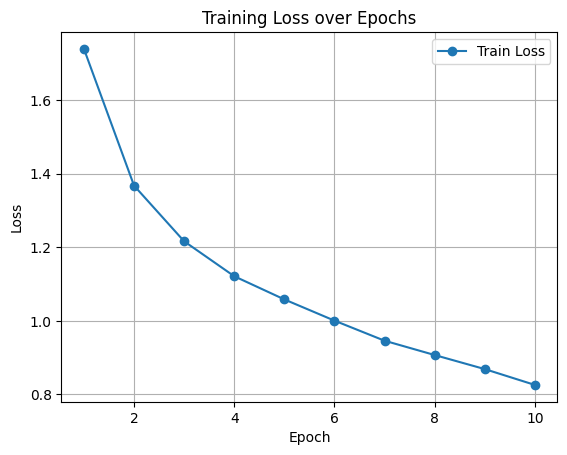

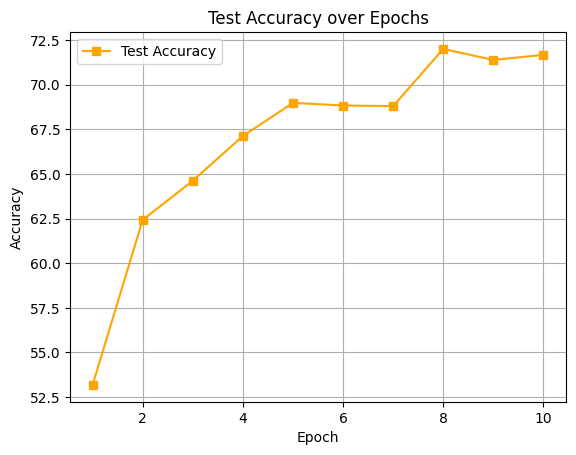

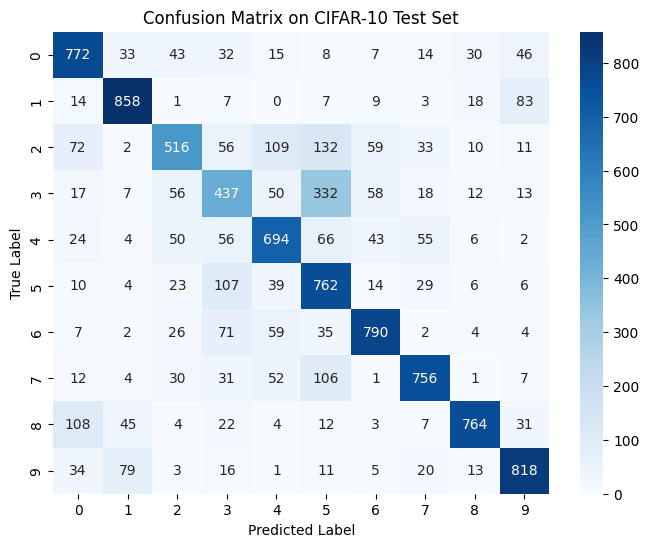

Prediction: [3 8 1 0 6 6 1 4 3 1]
Actual:     [3 8 8 0 6 6 1 6 3 1]


In [8]:
# 步骤六：模型评估
# 6.1 最后一次测试
final_acc, pred_y, true_y = test()
print(f"\nFinal Test Accuracy: {final_acc:.2f}%")

# 6.2 绘制训练loss变化曲线
plt.figure()
plt.plot(range(1, EPOCH+1), train_losses, marker='o', label='Train Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()
plt.grid(True)
plt.savefig('./output/train_loss_curve.png')
plt.show()

# 6.3 绘制测试准确率变化曲线
plt.figure()
plt.plot(range(1, EPOCH+1), test_accuracies, marker='s', color='orange', label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Test Accuracy over Epochs")
plt.legend()
plt.grid(True)
plt.savefig('./output/test_accuracy_curve.png')
plt.show()

# 6.4 绘制混淆矩阵
conf_mat = confusion_matrix(true_y.numpy(), pred_y.numpy())

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on CIFAR-10 Test Set")
plt.savefig('./output/confusion_matrix.png')
plt.show()

# 6.5 打印前10个预测结果
print('Prediction:', pred_y[:10].numpy())
print('Actual:    ', true_y[:10].numpy())

In [9]:
# 步骤七：保存模型与结果
# 请在此处编写代码：保存模型
model_save_path = './output/cifar10_cnn_model.pth'
torch.save(cnn.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to ./output/cifar10_cnn_model.pth


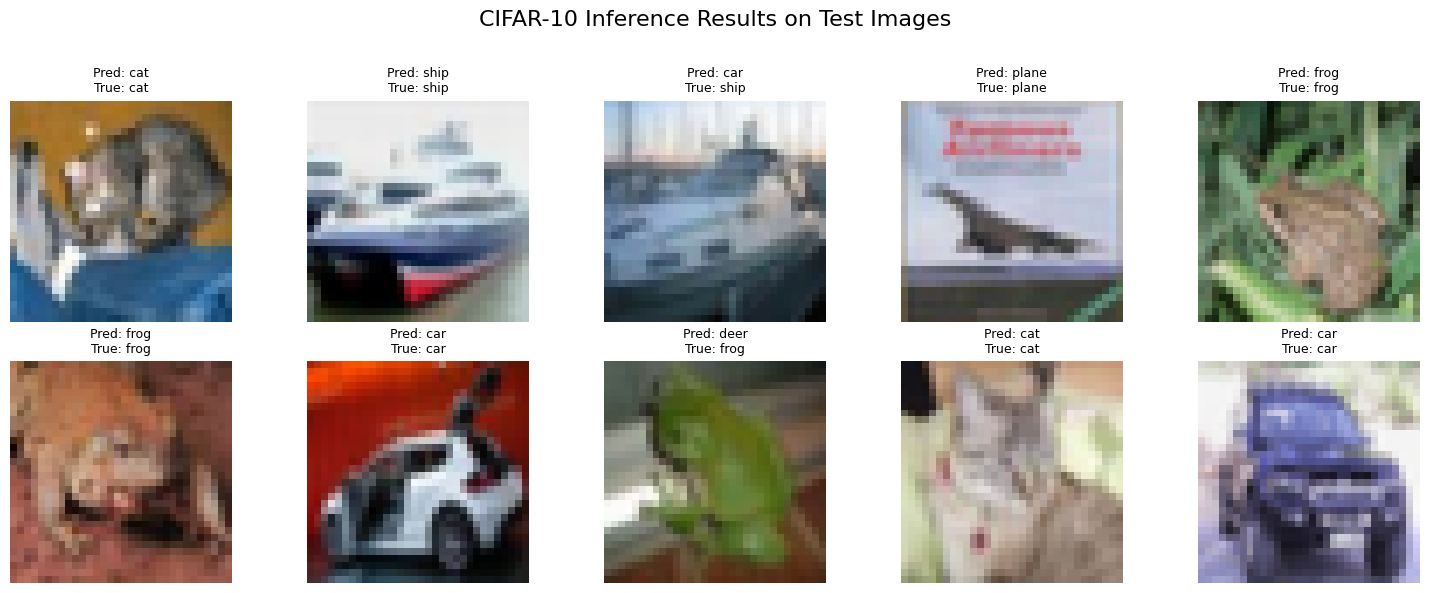

In [10]:
# 步骤八：推理结果可视化
# 8.1 CIFAR10 类别标签
classes = ['plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# 8.2 可视化推理函数
def visualize_cifar10_predictions(model, test_loader, device='cpu', num_images=10):
    """
    可视化模型在 CIFAR-10 测试集上的部分预测结果（RGB 彩色图）
    """
    model.eval() # 请在此处编写代码：将模型设置为 eval 模式
    shown = 0
    plt.figure(figsize=(15, 6)) # Adjusted figure size for better layout with 10 images

    # CIFAR-10 Normalization parameters (must match those used in training transform)
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).to(device)
    std = torch.tensor([0.2023, 0.1994, 0.2010]).to(device)

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device) # 请在此处编写代码：将 inputs 和 targets 迁移到指定设备
            outputs = model(inputs) # 请在此处编写代码：前向传播获得模型输出
            _, predicted = torch.max(outputs, 1) # 请在此处编写代码：获取预测结果

            for i in range(inputs.size(0)):
                if shown >= num_images:
                    break

                img_tensor = inputs[i] # Get the i-th image tensor
                # Denormalize: img = img * std + mean
                # Permute from (C, H, W) to (H, W, C) for matplotlib
                img = img_tensor.permute(1, 2, 0) * std + mean # 请在此处编写代码：提取第 i 张图像并反归一化
                img = img.cpu().numpy() # Move to CPU and convert to numpy
                img = img.clip(0, 1) # Clip values to [0,1] in case of floating point inaccuracies


                true_label = classes[targets[i].item()] # 请在此处编写代码：获取真实类别名称
                pred_label = classes[predicted[i].item()] # 请在此处编写代码：获取预测类别名称

                plt.subplot(2, (num_images + 1) // 2, shown + 1)
                plt.imshow(img)
                plt.title(f"Pred: {pred_label}\nTrue: {true_label}", fontsize=9) # Added newline for better readability
                plt.axis('off')
                shown += 1

            if shown >= num_images:
                break

    plt.suptitle("CIFAR-10 Inference Results on Test Images", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
    plt.savefig('./output/cifar10_test_predictions.png')
    plt.show()

# 8.3 执行推理可视化
# Ensure the model is on the correct device for visualization if different from training DEVICE
# For visualization, it's often easier to move model to CPU if it was on NPU/GPU and inputs are handled on CPU
# However, the function takes 'device' as an argument, so we use the original DEVICE
visualize_cifar10_predictions(cnn, test_loader, device=DEVICE, num_images=10)